# Encoding URLs

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ROOT_DIR = os.path.dirname(os.path.abspath(""))

file = os.path.join(ROOT_DIR, "data/sitges_access.csv")
df = pd.read_csv(file)
df.head()

,Unnamed: 0,server_name,IP,logname,authenticate,date,petition,URL,status,bytes,referer,user-agent,level
0,0,sitgesanytime.com,47.76.35.19,-,-,2024-01-22 00:00:00+01:00,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,301,4840,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0
1,1,www.sitgesanytime.com,47.76.35.19,-,-,2024-01-22 00:00:01+01:00,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,200,5223,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0
2,2,www.sitgesanytime.com,40.77.167.53,-,-,2024-01-22 00:00:06+01:00,GET,/ca/noticias/84/sitges-obt%C3%A9-el-certificat...,404,2509,-,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge...",5
3,3,sitgesanytime.com,47.76.35.19,-,-,2024-01-22 00:00:06+01:00,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,301,4840,-,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,0
4,4,www.sitgesanytime.com,47.76.35.19,-,-,2024-01-22 00:00:07+01:00,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,200,5260,-,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,0


In [2]:
counts = pd.Series([str(u).split(" ")[-1] for u in df["URL"].unique()]).value_counts()
{url: count for url, count in counts.items() if count > 1}

{'HTTP/1.1': 69449, 'HTTP/2.0': 25303, 'HTTP/1.0': 158}

In [3]:
len(df[~df["URL"].str.contains("HTTP").astype(bool)])

432

In [4]:
clean_url = df[df["URL"].str.contains("HTTP").astype(bool)]["URL"].dropna()
counts = pd.Series([str(u).split(" ")[-1] for u in clean_url]).value_counts()
{url: f"{count/len(df):.2f}%" for url, count in counts.items()}

{'HTTP/2.0': '0.82%', 'HTTP/1.1': '0.18%', 'HTTP/1.0': '0.00%'}

## Tokenization

In [5]:
corpus = clean_url.to_list()
vocab_init = set(" ".join(corpus))
print(vocab_init)
corpus[:5]

{'j', 'C', 'r', 'N', '0', 'G', 'u', '=', 'M', '/', 'H', 'v', 'q', ':', 'd', ';', '9', 'h', 's', 'T', 'p', '}', '{', 'S', 'o', '3', 'Z', 'Q', ',', 'z', '+', 'g', '!', 'V', '%', '*', 'B', 'b', 'K', 'W', '[', 'F', 't', 'm', 'n', 'D', '5', 'R', 'w', '4', '7', '1', ' ', "'", '.', 'P', '-', 'k', 'a', 'y', 'E', '6', 'X', 'l', 'x', 'J', '?', '$', ']', ')', '8', 'Y', '_', 'U', 'f', '>', 'e', 'I', 'O', '2', 'c', '\\', '&', 'A', 'i', '@', '(', 'L'}


['/fr/pag492/explora-platges-i-ports-2/id12/les-anquines.htm HTTP/1.1',
 '/fr/pag492/explora-platges-i-ports-2/id12/les-anquines.htm HTTP/1.1',
 '/ca/noticias/84/sitges-obt%C3%A9-el-certificat-de-turisme-responsable-biosphere.html HTTP/2.0',
 '/fr/pag492/explora-platges-i-ports-2/id12/les-anquines.htm HTTP/1.1',
 '/fr/pag492/explora-platges-i-ports-2/id12/les-anquines.htm HTTP/1.1']

### Byte Pair Encoding (BPE)

In [34]:
from tokenizers import pre_tokenizers
alphabet = " ".join(pre_tokenizers.ByteLevel.alphabet())
alphabet[alphabet.find("ç")]

'ç'

In [6]:
from tokenizers import ByteLevelBPETokenizer # https://github.com/huggingface/tokenizers/blob/main/bindings/python/py_src/tokenizers/implementations/byte_level_bpe.py
tokenizer = ByteLevelBPETokenizer()

special_tokens = ["<s>", "<pad>", "</s>", "<unk>", "<mask>"]
tokenizer.train_from_iterator(corpus, vocab_size=1000, min_frequency=2, 
							  special_tokens=special_tokens)

In [7]:
tokenizer.save_model(os.path.join(ROOT_DIR, "models/"), prefix="bpe")

['/media/eric/D/repos/Synthesis-Project-1/models/bpe-vocab.json',
 '/media/eric/D/repos/Synthesis-Project-1/models/bpe-merges.txt']

In [66]:
tokenizer = ByteLevelBPETokenizer(
	vocab = os.path.join(ROOT_DIR, "models/", "bpe-vocab.json"),
	merges = os.path.join(ROOT_DIR, "models/", "bpe-merges.txt")
)

In [67]:
# print 5 longest vocab items
sorted(tokenizer.get_vocab(), key=len, reverse=True)[:5]

['oncssanimationend',
 'pictogramestaules',
 'responsivemenu',
 'cookiemanager',
 'internacional']

In [68]:
clean_url.iloc[0], clean_url.iloc[-1]

('/fr/pag492/explora-platges-i-ports-2/id12/les-anquines.htm HTTP/1.1',
 '/plantilles/turisme/css/estils-capcalera.css?v=3 HTTP/2.0')

In [69]:
print(tokenizer.encode(clean_url.iloc[0]).tokens)
print(tokenizer.encode(clean_url.iloc[-1]).tokens)

['/', 'fr', '/', 'pag', '492', '/', 'explora', '-', 'platges', '-', 'i', '-', 'ports', '-', '2', '/', 'id', '12', '/', 'les', '-', 'an', 'qu', 'in', 'es', '.', 'htm', 'ĠHTTP', '/', '1', '.', '1']
['/', 'plantilles', '/', 'turisme', '/', 'css', '/', 'estils', '-', 'capcalera', '.', 'css', '?', 'v', '=', '3', 'ĠHTTP', '/', '2', '.', '0']


In [71]:
tokenizer.encode("caça", add_special_tokens=True).tokens

['ca', 'Ã', '§', 'a']

### Wordpiece

In [100]:
from tokenizers import BertWordPieceTokenizer
tokenizer = BertWordPieceTokenizer()

special_tokens = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
tokenizer.train_from_iterator(corpus, vocab_size=1000, min_frequency=2, special_tokens=special_tokens)

In [101]:
tokenizer.save_model(os.path.join(ROOT_DIR, "models/"), prefix="wordpiece")

['/media/eric/D/repos/Synthesis-Project-1/models/wordpiece-vocab.txt']

In [102]:
tokenizer = BertWordPieceTokenizer(
	vocab = os.path.join(ROOT_DIR, "models/", "wordpiece-vocab.txt"),
)

In [103]:
# print 5 longest vocab items
sorted(tokenizer.get_vocab(), key=len, reverse=True)[:5]

['oncssanimationend',
 'pictogramestaules',
 'oncssanimation',
 'responsivemenu',
 '##ssanimation']

In [104]:
print(tokenizer.encode(clean_url.iloc[0]).tokens)
print(tokenizer.encode(clean_url.iloc[-1]).tokens)

['[CLS]', '/', 'fr', '/', 'pag', '##49', '##2', '/', 'explora', '-', 'platges', '-', 'i', '-', 'ports', '-', '2', '/', 'id1', '##2', '/', 'les', '-', 'an', '##qu', '##ine', '##s', '.', 'htm', 'http', '/', '1', '.', '1', '[SEP]']
['[CLS]', '/', 'plantilles', '/', 'turisme', '/', 'css', '/', 'estils', '-', 'capcalera', '.', 'css', '?', 'v', '=', '3', 'http', '/', '2', '.', '0', '[SEP]']


### Character-level BPE

In [113]:
initial_alphabet = list(set("".join(corpus)))
len(initial_alphabet)

88

In [114]:
from tokenizers import CharBPETokenizer
tokenizer = CharBPETokenizer(suffix="</w>", bert_normalizer=True)
tokenizer.train_from_iterator(corpus, vocab_size=1000, min_frequency=10, special_tokens=["<unk>"], initial_alphabet=initial_alphabet)
tokenizer.save_model(os.path.join(ROOT_DIR, "models/"), prefix="charbpe")
tokenizer = CharBPETokenizer(
	vocab=os.path.join(ROOT_DIR, "models/", "charbpe-vocab.json"),
	merges=os.path.join(ROOT_DIR, "models/", "charbpe-merges.txt")
)

In [115]:
set(initial_alphabet) < set(tokenizer.get_vocab().keys())

True

In [116]:
clean_url.iloc[0]

'/fr/pag492/explora-platges-i-ports-2/id12/les-anquines.htm HTTP/1.1'

In [117]:
print(tokenizer.encode(clean_url.iloc[0], add_special_tokens=True).tokens)

['/</w>', 'fr</w>', '/</w>', 'pag', '4', '92</w>', '/</w>', 'explora</w>', '-</w>', 'platges</w>', '-</w>', 'i</w>', '-</w>', 'ports</w>', '-</w>', '2</w>', '/</w>', 'id1', '2</w>', '/</w>', 'les</w>', '-</w>', 'an', 'qu', 'in', 'es</w>', '.</w>', 'htm</w>', 'HTTP</w>', '/</w>', '1</w>', '.</w>', '1</w>']


In [118]:
from tqdm import tqdm
from collections import Counter

tokenizer = CharBPETokenizer(
	vocab=os.path.join(ROOT_DIR, "models/", "charbpe-vocab.json"),
	merges=os.path.join(ROOT_DIR, "models/", "charbpe-merges.txt")
)

tokenized_corpus = []
for url in tqdm(corpus):
	tokenized_corpus.append(tokenizer.encode(url).tokens)

In [95]:
def preprocess(tokenized_corpus, min_frequency=5):
	token_counts = Counter([token for url in tokenized_corpus for token in url])
	trimmed = []
	for url in tqdm(tokenized_corpus):
		trimmed_url = []
		for token in url:
			if token_counts[token] >= min_frequency:
				trimmed_url.append(token)
			else:
				trimmed_url.append("<unk>")
		trimmed.append(trimmed_url)
	return trimmed

trimmed_tokenized_corpus = preprocess(tokenized_corpus)

100%|██████████| 1076959/1076959 [00:05<00:00, 187572.18it/s]


In [96]:
tokens = [token for url in trimmed_tokenized_corpus for token in url]
len(trimmed_tokenized_corpus), len(tokens), len(set(tokens))

(1076959, 25457221, 923)

In [119]:
vocab_t = set(tokenizer.get_vocab().keys())
vocab_c = set(tokens)
len(vocab_t), len(vocab_c)

(1000, 923)

In [120]:
missing = vocab_t - vocab_c
not_missing = vocab_t & vocab_c

In [121]:
to_remove = []
for t1 in missing:
	found = False
	for t2 in not_missing:
		if t1 in t2:
			# print(t1, t2)
			found = True
	if not found:
		to_remove.append(t1)
to_remove

[' ',
 ']',
 '{</w>',
 '[',
 '}</w>',
 '*',
 '*</w>',
 '}',
 '></w>',
 '{',
 ']</w>',
 '[</w>']

In [124]:
" " in tokenizer.get_vocab(), tokenizer.encode("hello world").tokens

(True, ['hel', 'l', 'o</w>', 'wor', 'l', 'd</w>'])

In [125]:
"<unk>" in "".join([t for u in trimmed_tokenized_corpus for t in u]), "]" in "".join([t for u in tokenized_corpus for t in u])

(True, True)

In [126]:
tokenizer.encode("hello]").tokens

['hel', 'l', 'o</w>', ']</w>']

In [105]:
import json
with open(os.path.join(ROOT_DIR, "models/", "charbpe-vocab.json"), "r") as f:
	vocab = json.load(f)
vocab_tokens = list(vocab.keys())
vocab_tokens[:5]

['<unk>', ' ', '!', '$', '%']

In [136]:
new_vocab = [t for t in vocab_tokens if t not in to_remove]
len(new_vocab), len(vocab_tokens)

(988, 1000)

In [138]:
new_vocab = {t:i for i,t in enumerate(new_vocab)}
list(zip(new_vocab.items()))[:5]

[(('<unk>', 0),), (('!', 1),), (('$', 2),), (('%', 3),), (('&', 4),)]

In [139]:
with open(os.path.join(ROOT_DIR, "models/", "charbpe-vocab.json"), "w") as f:
	json.dump(new_vocab, f)

In [140]:
tokenizer = CharBPETokenizer(
	vocab=os.path.join(ROOT_DIR, "models/", "charbpe-vocab.json"),
	merges=os.path.join(ROOT_DIR, "models/", "charbpe-merges.txt")
)
len(tokenizer.get_vocab())

988

## Embeddings

### Word2Vec SkipGram (vanilla)

In [11]:
from tokenizers import CharBPETokenizer
tokenizer = CharBPETokenizer(
	vocab=os.path.join(ROOT_DIR, "models/", "charbpe-vocab.json"),
	merges=os.path.join(ROOT_DIR, "models/", "charbpe-merges.txt")
)

In [8]:
from tqdm import tqdm
tokenized_corpus = []
for url in tqdm(corpus):
	tokenized_corpus.append(tokenizer.encode(url).tokens)
tokenized_corpus[:3]

100%|██████████| 1076959/1076959 [00:39<00:00, 27195.69it/s]


[['/</w>',
  'fr</w>',
  '/</w>',
  'pag',
  '4',
  '92</w>',
  '/</w>',
  'explora</w>',
  '-</w>',
  'platges</w>',
  '-</w>',
  'i</w>',
  '-</w>',
  'ports</w>',
  '-</w>',
  '2</w>',
  '/</w>',
  'id1',
  '2</w>',
  '/</w>',
  'les</w>',
  '-</w>',
  'an',
  'qu',
  'in',
  'es</w>',
  '.</w>',
  'htm</w>',
  'HTTP</w>',
  '/</w>',
  '1</w>',
  '.</w>',
  '1</w>'],
 ['/</w>',
  'fr</w>',
  '/</w>',
  'pag',
  '4',
  '92</w>',
  '/</w>',
  'explora</w>',
  '-</w>',
  'platges</w>',
  '-</w>',
  'i</w>',
  '-</w>',
  'ports</w>',
  '-</w>',
  '2</w>',
  '/</w>',
  'id1',
  '2</w>',
  '/</w>',
  'les</w>',
  '-</w>',
  'an',
  'qu',
  'in',
  'es</w>',
  '.</w>',
  'htm</w>',
  'HTTP</w>',
  '/</w>',
  '1</w>',
  '.</w>',
  '1</w>'],
 ['/</w>',
  'ca</w>',
  '/</w>',
  'noticias</w>',
  '/</w>',
  '8',
  '4</w>',
  '/</w>',
  'sitges</w>',
  '-</w>',
  'ob',
  't</w>',
  '%</w>',
  'C3</w>',
  '%</w>',
  'A',
  '9</w>',
  '-</w>',
  'el</w>',
  '-</w>',
  'cer',
  'ti',
  'fi',
  'ca

In [9]:
word2idx = tokenizer.get_vocab()
idx2word = {idx: word for word, idx in word2idx.items()}

In [10]:
def get_training_data(tokenized_corpus, word2idx, window_size=2):
	training_data = []
	for sentence in tqdm(tokenized_corpus):
		sentence_indices = [word2idx[word] for word in sentence]
		for center_word_pos in range(len(sentence_indices)):
			for w in range(-window_size, window_size + 1):
				context_word_pos = center_word_pos + w
				if context_word_pos < 0 or context_word_pos >= len(sentence_indices) or center_word_pos == context_word_pos:
					continue
				center_word_idx = sentence_indices[center_word_pos]
				context_word_idx = sentence_indices[context_word_pos]
				training_data.append((center_word_idx, context_word_idx))
	return training_data

training_data = get_training_data(tokenized_corpus, word2idx)
training_data[0]

100%|██████████| 1076959/1076959 [00:21<00:00, 50735.66it/s]


(165, 363)

In [12]:
[(idx2word[center], idx2word[context]) for center, context in training_data[:10]]

[('/</w>', 'fr</w>'),
 ('/</w>', '/</w>'),
 ('fr</w>', '/</w>'),
 ('fr</w>', '/</w>'),
 ('fr</w>', 'pag'),
 ('/</w>', '/</w>'),
 ('/</w>', 'fr</w>'),
 ('/</w>', 'pag'),
 ('/</w>', '4'),
 ('pag', 'fr</w>')]

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

class Word2VecSkipGram(nn.Module):
	def __init__(self, vocab_size, embedding_dim):
		super(Word2VecSkipGram, self).__init__()
		self.embeddings = nn.Embedding(vocab_size, embedding_dim)
		self.linear = nn.Linear(embedding_dim, vocab_size)
		
	def forward(self, x):
		x = self.embeddings(x)
		x = self.linear(F.relu(x))
		return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Word2VecSkipGram(vocab_size=len(word2idx), embedding_dim=100).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model

Word2VecSkipGram(
  (embeddings): Embedding(1000, 100)
  (linear): Linear(in_features=100, out_features=1000, bias=True)
)

In [31]:
class Word2VecDataset(Dataset):
	def __init__(self, training_data):
		self.training_data = training_data
		
	def __len__(self):
		return len(self.training_data)
	
	def __getitem__(self, idx):
		center_word_idx, context_word_idx = self.training_data[idx]
		return center_word_idx, context_word_idx
	
train_size = int(0.6 * len(training_data))
val_size = int(0.2 * len(training_data))
test_size = len(training_data) - train_size - val_size
train_data = training_data[:train_size]
val_data = training_data[train_size:train_size + val_size]
test_data = training_data[-test_size:]

train_dataset = Word2VecDataset(train_data)
val_dataset = Word2VecDataset(val_data)
test_dataset = Word2VecDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [32]:
def train(model, criterion, optimizer, train_loader, val_loader, device, n_epochs=10):
	training_losses = []
	val_losses = []
	for epoch in range(n_epochs):
		model.train()
		train_loss = 0
		for i, (center_word_idxs, context_word_idxs) in enumerate(train_loader):
			center_word_idxs = center_word_idxs.to(device)
			context_word_idxs = context_word_idxs.to(device)
			optimizer.zero_grad()
			outputs = model(center_word_idxs)
			loss = criterion(outputs, context_word_idxs)
			loss.backward()
			optimizer.step()
			train_loss += loss.item()
			print(f"Epoch {epoch + 1}/{n_epochs} Batch {i + 1}/{len(train_loader)} Loss: {loss.item():.4f}", end="\r")
		training_losses.append(train_loss / len(train_loader))
		model.eval()
		val_loss = 0
		with torch.no_grad():
			for center_word_idxs, context_word_idxs in val_loader:
				center_word_idxs = center_word_idxs.to(device)
				context_word_idxs = context_word_idxs.to(device)
				outputs = model(center_word_idxs)
				loss = criterion(outputs, context_word_idxs)
				val_loss += loss.item()
		val_losses.append(val_loss / len(val_loader))
		print(f"Epoch {epoch + 1}/{n_epochs} Training Loss: {training_losses[-1]:.4f} Validation Loss: {val_losses[-1]:.4f}", end="\r")
	return training_losses, val_losses

def test(model, criterion, test_loader, device):
	model.eval()
	test_loss = 0
	with torch.no_grad():
		for center_word_idxs, context_word_idxs in test_loader:
			center_word_idxs = center_word_idxs.to(device)
			context_word_idxs = context_word_idxs.to(device)
			outputs = model(center_word_idxs)
			loss = criterion(outputs, context_word_idxs)
			test_loss += loss.item()
	return test_loss / len(test_loader)

def plot_losses(training_losses, val_losses):
	plt.plot(training_losses, label="Training Loss")
	plt.plot(val_losses, label="Validation Loss")
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	plt.show()

In [33]:
train_losses, val_losses = train(model, criterion, optimizer, train_loader, val_loader, device, n_epochs=1)

In [34]:
test(model, criterion, test_loader, device)

3.014350344884184

In [39]:
embeddings = model.embeddings.weight.data.cpu().numpy()
embeddings.shape

(1000, 100)

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings)
reduced_embeddings.shape

(1000, 2)

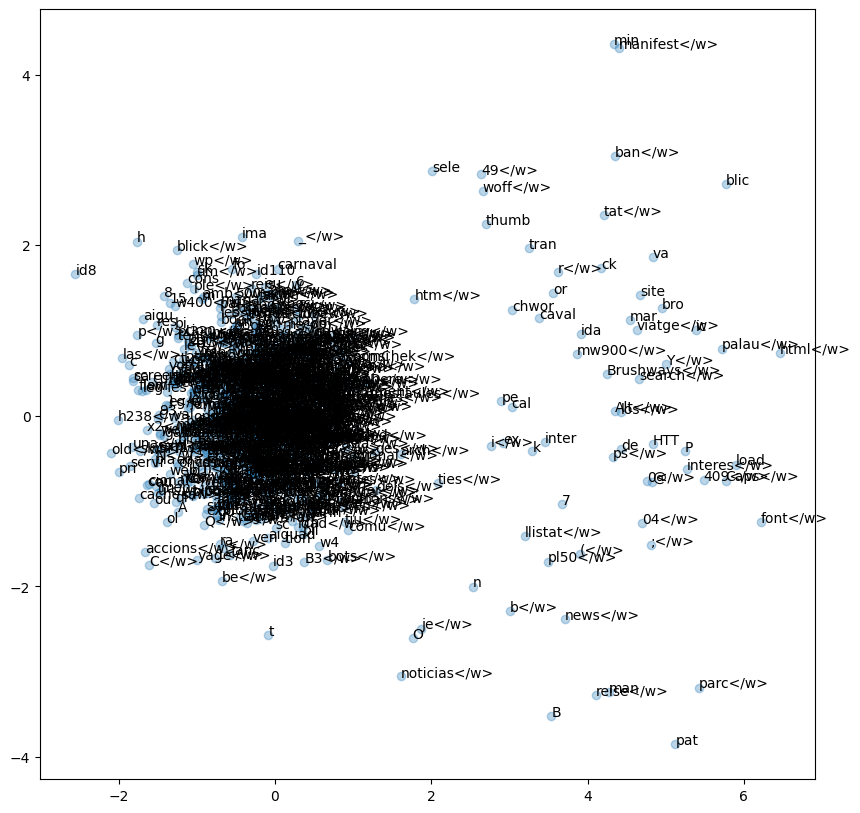

In [41]:
plt.figure(figsize=(10, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.3)
for i, word in enumerate(word2idx.keys()):
	plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
plt.show()

In [54]:
# test model with a token
token = "HTTP</w>"
token_idx = word2idx[token]
with torch.no_grad():
	out_vector = model(torch.tensor([token_idx]).to(device), None)
	out_probs = F.softmax(out_vector, dim=1).cpu().numpy()

# top 5
top5_idx = out_probs.argsort()[0][::-1][:5]
top5_tokens = [idx2word[idx] for idx in top5_idx]
top5_tokens

['/</w>', '2</w>', '.</w>', '=</w>', '1</w>']

### Word2Vec SkipGram (implemented as in Mikolov et al.)
With Subsampling and Negative sampling

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from tokenizers import CharBPETokenizer
from collections import Counter
import numpy as np
import random
import gc, os

In [7]:
tokenizer = CharBPETokenizer(
	vocab=os.path.join(ROOT_DIR, "models/", "charbpe-vocab.json"),
	merges=os.path.join(ROOT_DIR, "models/", "charbpe-merges.txt")
)

tokenized_corpus = []
for url in tqdm(corpus):
	tokenized_corpus.append(tokenizer.encode(url).tokens)

  0%|          | 0/1076959 [00:00<?, ?it/s]

100%|██████████| 1076959/1076959 [00:41<00:00, 26253.68it/s]


In [8]:
def preprocess(tokenized_corpus, min_frequency=5):
	token_counts = Counter([token for url in tokenized_corpus for token in url])
	trimmed = []
	for url in tqdm(tokenized_corpus):
		trimmed_url = []
		for token in url:
			if token_counts[token] >= min_frequency:
				trimmed_url.append(token)
			else:
				trimmed_url.append("<unk>")
		trimmed.append(trimmed_url)
	return trimmed

trimmed_tokenized_corpus = preprocess(tokenized_corpus)

100%|██████████| 1076959/1076959 [00:07<00:00, 151562.86it/s]


In [9]:
tokens = [token for url in trimmed_tokenized_corpus for token in url]
len(trimmed_tokenized_corpus), len(tokens), len(set(tokens)), len(tokenizer.get_vocab())

(1076959, 25457221, 923, 988)

In [10]:
def create_lookup_tables(words):
	word_counts = Counter(words)
	vocab = sorted(word_counts, key=word_counts.get, reverse=True)
	idx2word = {idx: word for idx, word in enumerate(vocab)}
	word2idx = {word: idx for idx, word in idx2word.items()}
	return word2idx, idx2word, vocab

word2idx, idx2word, vocab = create_lookup_tables(tokens)
vocab[:5]

['/</w>', '.</w>', '-</w>', 'HTTP</w>', '0</w>']

In [11]:
Counter(tokens)["<unk>"]

54

#### Subsampling

In [12]:
tokens_idx = [word2idx[word] for word in tokens]
corpus_idx = [[word2idx[word] for word in url] for url in trimmed_tokenized_corpus]
threshold=1e-2
token_counts = Counter(tokens_idx)
total_tokens = len(tokens_idx)
freq_ratios = {token: count / total_tokens for token, count in token_counts.items()}
p_drop = {token: 1 - np.sqrt(threshold / freq_ratios[token]) for token in token_counts}
subsampled_corpus = [[token for token in url if random.random() < (1 - p_drop[token])] for url in tqdm(corpus_idx)]
l1 = len(tokens_idx)
l2 = len([token for url in subsampled_corpus for token in url])
l1, l2, l2 / l1

100%|██████████| 1076959/1076959 [00:06<00:00, 166602.05it/s]


(25457221, 15690828, 0.616360599611403)

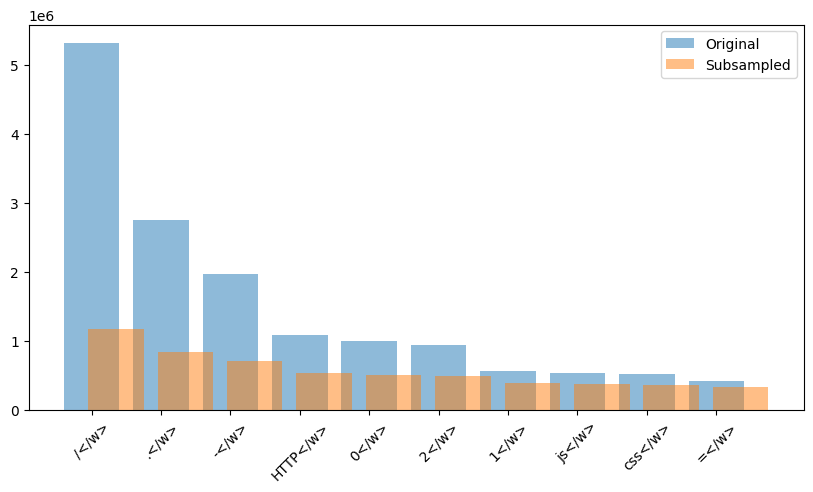

In [13]:
token_counts2 = Counter([token for url in subsampled_corpus for token in url])

# double bar plot of each token in token_counts vs token_counts2
plt.figure(figsize=(10, 5))
plt.bar(range(10), [count for token, count in token_counts.most_common(10)], alpha=0.5, label="Original")
plt.bar(np.array(range(10)) + 0.35, [count for token, count in token_counts2.most_common(10)], alpha=0.5, label="Subsampled")
plt.xticks(range(10), [idx2word[token] for token, count in token_counts.most_common(10)], rotation=45)
plt.legend()
plt.show()

In [14]:
print(trimmed_tokenized_corpus[3])
print([idx2word[i] for i in subsampled_corpus[3]])

['/</w>', 'fr</w>', '/</w>', 'pag', '4', '92</w>', '/</w>', 'explora</w>', '-</w>', 'platges</w>', '-</w>', 'i</w>', '-</w>', 'ports</w>', '-</w>', '2</w>', '/</w>', 'id1', '2</w>', '/</w>', 'les</w>', '-</w>', 'an', 'qu', 'in', 'es</w>', '.</w>', 'htm</w>', 'HTTP</w>', '/</w>', '1</w>', '.</w>', '1</w>']
['fr</w>', 'pag', '4', '92</w>', 'explora</w>', '-</w>', 'platges</w>', 'i</w>', 'ports</w>', '2</w>', 'id1', 'les</w>', 'an', 'qu', 'in', 'es</w>', 'htm</w>', '/</w>', '1</w>', '1</w>']


#### Skip-Gram

In [16]:
def get_context(sentence, pos, max_window_size):
	r = random.randint(1, max_window_size)
	start = max(0, pos - r)
	end = min(pos + r, len(sentence))
	context = sentence[start:pos] + sentence[pos+1:end+1] # +1 because we exclude idx word
	return context

context_size = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
[idx2word[i] for i in get_context(subsampled_corpus[3], 5, context_size)]

['pag',
 '4',
 '92</w>',
 'explora</w>',
 'platges</w>',
 'i</w>',
 'ports</w>',
 '2</w>']

In [60]:
def _get_batches(words: list[int], batch_size: int, max_window_size: int=5, full=False):
	if full:
		batch_x, batch_y, ls = [], [], []
		for i, word in enumerate(words):
			x = [word]
			y = get_context(words, i, max_window_size)
			batch_x.extend(x * len(y))
			batch_y.extend(y)
			ls.append(len(y))
		yield batch_x, batch_y, ls
	else:
		n_batches = len(words) // batch_size
		remainder = len(words) % batch_size

		for i in range(0, n_batches*batch_size, batch_size):
			if (i == (n_batches-1) * batch_size) and (remainder != 0):
				# last batch includes remainder
				batch_of_center_words = words[i:]
			else:
				batch_of_center_words = words[i:i+batch_size]
			batch_x, batch_y, ls = [], [], []
			for ii in range(len(batch_of_center_words)):
				x = [batch_of_center_words[ii]]
				y = get_context(batch_of_center_words, ii, max_window_size)
				batch_x.extend(x * len(y))
				batch_y.extend(y)
				ls.append(len(y))
			yield batch_x, batch_y, ls

def get_batches(sentences: list[list[int]], batch_size: int, max_window_size: int=5):
	batch_x, batch_y = [], []
	l = 0
	for sentence in sentences:
		for batch in _get_batches(sentence, batch_size, max_window_size, full=len(sentence) <= batch_size):
			batch_x.extend(batch[0])
			batch_y.extend(batch[1])
			l += len(batch[2])
			while l >= batch_size:
				rem = l - batch_size
				if rem == 0:
					yield batch_x, batch_y
					batch_x, batch_y = [], []
					l = 0
				else:
					b_sum = sum(batch[2][-rem:])
					yield batch_x[:-b_sum], batch_y[:-b_sum]
					batch_x, batch_y = batch_x[-b_sum:], batch_y[-b_sum:]
					l = rem
	if l > 0:
		yield batch_x, batch_y

In [27]:
print([idx2word[i] for i in subsampled_corpus[3]])

['fr</w>', 'pag', '4', '92</w>', 'explora</w>', '-</w>', 'platges</w>', 'i</w>', 'ports</w>', '2</w>', 'id1', 'les</w>', 'an', 'qu', 'in', 'es</w>', 'htm</w>', '/</w>', '1</w>', '1</w>']


In [61]:
for i, batch in enumerate(_get_batches(subsampled_corpus[3], 5)):
	print(len(batch[0]), len(batch[1]))
	print([(idx2word[i1],idx2word[i2]) for i1,i2 in np.array(batch[:2]).T])
	if i == 6:
		break

14 14
[('fr</w>', 'pag'), ('fr</w>', '4'), ('pag', 'fr</w>'), ('pag', '4'), ('4', 'fr</w>'), ('4', 'pag'), ('4', '92</w>'), ('4', 'explora</w>'), ('92</w>', '4'), ('92</w>', 'explora</w>'), ('explora</w>', 'fr</w>'), ('explora</w>', 'pag'), ('explora</w>', '4'), ('explora</w>', '92</w>')]
18 18
[('-</w>', 'platges</w>'), ('-</w>', 'i</w>'), ('-</w>', 'ports</w>'), ('-</w>', '2</w>'), ('platges</w>', '-</w>'), ('platges</w>', 'i</w>'), ('i</w>', '-</w>'), ('i</w>', 'platges</w>'), ('i</w>', 'ports</w>'), ('i</w>', '2</w>'), ('ports</w>', '-</w>'), ('ports</w>', 'platges</w>'), ('ports</w>', 'i</w>'), ('ports</w>', '2</w>'), ('2</w>', '-</w>'), ('2</w>', 'platges</w>'), ('2</w>', 'i</w>'), ('2</w>', 'ports</w>')]
18 18
[('id1', 'les</w>'), ('id1', 'an'), ('id1', 'qu'), ('id1', 'in'), ('les</w>', 'id1'), ('les</w>', 'an'), ('les</w>', 'qu'), ('les</w>', 'in'), ('an', 'id1'), ('an', 'les</w>'), ('an', 'qu'), ('an', 'in'), ('qu', 'an'), ('qu', 'in'), ('in', 'id1'), ('in', 'les</w>'), ('in',

In [62]:
for i, batch in enumerate(get_batches(subsampled_corpus, 5)):
	print(len(batch[0]), len(batch[1]))
	print([(idx2word[i1],idx2word[i2]) for i1,i2 in np.array(batch).T])
	if i == 3:
		break

15 15
[('fr</w>', 'pag'), ('fr</w>', '4'), ('fr</w>', '92</w>'), ('fr</w>', 'explora</w>'), ('pag', 'fr</w>'), ('pag', '4'), ('4', 'fr</w>'), ('4', 'pag'), ('4', '92</w>'), ('4', 'explora</w>'), ('92</w>', 'pag'), ('92</w>', '4'), ('92</w>', 'explora</w>'), ('explora</w>', '4'), ('explora</w>', '92</w>')]
18 18
[('-</w>', 'platges</w>'), ('-</w>', '-</w>'), ('-</w>', 'i</w>'), ('-</w>', 'ports</w>'), ('platges</w>', '-</w>'), ('platges</w>', '-</w>'), ('platges</w>', 'i</w>'), ('platges</w>', 'ports</w>'), ('-</w>', '-</w>'), ('-</w>', 'platges</w>'), ('-</w>', 'i</w>'), ('-</w>', 'ports</w>'), ('i</w>', '-</w>'), ('i</w>', 'ports</w>'), ('ports</w>', '-</w>'), ('ports</w>', 'platges</w>'), ('ports</w>', '-</w>'), ('ports</w>', 'i</w>')]
16 16
[('2</w>', '/</w>'), ('2</w>', 'id1'), ('2</w>', '/</w>'), ('2</w>', 'les</w>'), ('/</w>', '2</w>'), ('/</w>', 'id1'), ('/</w>', '/</w>'), ('/</w>', 'les</w>'), ('id1', '2</w>'), ('id1', '/</w>'), ('id1', '/</w>'), ('id1', 'les</w>'), ('/</w>', '

In [63]:
def cosine_similarity(embedding: nn.Embedding, n_valid_words: int=10, valid_window: int=30):
	"""
	Returns the cosine similarity of validation words with words in the embedding matrix.
		embedding: PyTorch embedding module
		n_valid_words: # of validation words (recommended to have even numbers)
	"""
	all_embeddings = embedding.weight  # (n_vocab, n_embed) 
	# sim = (a . b) / |a||b|
	magnitudes = all_embeddings.pow(2).sum(dim=1).sqrt().unsqueeze(0) # (1, n_vocab)
	
	# Pick validation words from 2 ranges: (0, window): common words & (1000, 1000+window): uncommon words 
	valid_words = 	random.sample(range(valid_window), n_valid_words//2) + \
					random.sample(range(100, 100+valid_window), n_valid_words//2)
	valid_words = torch.LongTensor(np.array(valid_words)).to(device) # (n_valid_words, 1)

	valid_embeddings = embedding(valid_words) # (n_valid_words, n_embed)
	# (n_valid_words, n_embed) * (n_embed, n_vocab) --> (n_valid_words, n_vocab) / 1, n_vocab)
	similarities = torch.mm(valid_embeddings, all_embeddings.t()) / magnitudes  # (n_valid_words, n_vocab)
	
	return valid_words, similarities

embedding = nn.Embedding(1000, 30).to(device)
valid_words, similarities = cosine_similarity(embedding)
valid_words, similarities.shape

(tensor([ 16,  21,  14,  22,   7, 118, 109, 125, 108, 129], device='cuda:0'),
 torch.Size([10, 1000]))

In [64]:
# negative sampling: https://www.baeldung.com/cs/nlps-word2vec-negative-sampling
# implemented as in: https://github.com/lukysummer/SkipGram_with_NegativeSampling_Pytorch

class SkipGram(nn.Module):
	def __init__(self, n_vocab, n_embed, noise_dist=None):
		super(SkipGram, self).__init__()
		self.n_vocab = n_vocab
		self.n_embed = n_embed
		self.noise_dist = noise_dist

		self.in_embed = nn.Embedding(n_vocab, n_embed)
		self.out_embed = nn.Embedding(n_vocab, n_embed)

		# Initialize embedding tables with uniform distribution
		# no need for Kaiming or other complex methods, skip-gram is simple not deep
		self.in_embed.weight.data.uniform_(-1, 1)
		self.out_embed.weight.data.uniform_(-1, 1)
	
	def forward_input(self, input_words):
		input_vectors = self.in_embed(input_words)
		return input_vectors
	
	def forward_target(self, output_words):
		output_vectors = self.out_embed(output_words)
		return output_vectors
	
	def forward_noise(self, batch_size, n_samples=5):
		""" Generate noise vectors with shape (batch_size, n_samples, n_embed)"""
		# If no Noise Distribution specified, sample noise words uniformly from vocabulary
		if self.noise_dist is None:
			noise_dist = torch.ones(self.n_vocab)
		else:
			noise_dist = self.noise_dist
			
		noise_words = torch.multinomial(input       = noise_dist,
										num_samples = batch_size*n_samples,
										replacement = True)
		noise_words = noise_words.to(device)
		
		# use context matrix for embedding noise samples
		noise_vectors = self.out_embed(noise_words).view(batch_size, n_samples, self.n_embed)
		
		return noise_vectors
	
class NegativeSamplingLoss(nn.Module):
	def __init__(self):
		super().__init__()

	def forward(self, 
				input_vectors, 
				output_vectors, 
				noise_vectors):
		
		batch_size, embed_size = input_vectors.shape
		
		input_vectors = input_vectors.view(batch_size, embed_size, 1)   # batch of column vectors
		output_vectors = output_vectors.view(batch_size, 1, embed_size) # batch of row vectors
		
		# log-sigmoid loss for correct pairs
		out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log().squeeze()
		
		# log-sigmoid loss for incorrect pairs
		noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
		noise_loss = noise_loss.squeeze().sum(1)  # sum the losses over the sample of noise vectors

		return -(out_loss + noise_loss).mean()  # average batch loss

In [65]:
# As defined in the paper by Mikolov et al.
token_counts = Counter([token for url in subsampled_corpus for token in url])
freq_ratio = {token: count / len(word2idx) for token, count in token_counts.items()}        
freq_ratio = np.array(sorted(freq_ratio.values(), reverse=True))
unigram_dist = freq_ratio / freq_ratio.sum()
noise_dist = torch.from_numpy(unigram_dist**0.75 / np.sum(unigram_dist**0.75))

In [66]:
embedding_dim = 30
model = SkipGram(len(vocab), embedding_dim, noise_dist=noise_dist).to(device)
criterion = NegativeSamplingLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
batch_size = 512

In [80]:
from IPython.display import clear_output

n_negative_samples = 5
n_epochs = 1
print_every = (50, 1000)
total_b = 0

l = len([t for u in subsampled_corpus for t in u])
s = int(np.ceil(l/batch_size))
bs = len(str(s))
for epoch in range(n_epochs):
	str2 = ""
	for i, (inputs, targets) in enumerate(get_batches(subsampled_corpus, batch_size, context_size)):
		total_b += 1
		inputs = torch.LongTensor(inputs).to(device)    # [b*n_context_words]
		targets = torch.LongTensor(targets).to(device)  # [b*n_context_words]
		
		optimizer.zero_grad()
		embedded_input_words = model.forward_input(inputs)
		embedded_target_words = model.forward_target(targets)
		embedded_noise_words = model.forward_noise(batch_size=inputs.shape[0], 
													n_samples=n_negative_samples)

		loss = criterion(embedded_input_words, embedded_target_words, embedded_noise_words)
		loss.backward()
		optimizer.step()
		
		if (i % print_every[1]) == 0:
			str2 = ""
			valid_idxs, similarities = cosine_similarity(model.in_embed)
			_, closest_idxs = similarities.topk(6)
			valid_idxs, closest_idxs = valid_idxs.to('cpu'), closest_idxs.to('cpu')
			
			for ii, v_idx in enumerate(valid_idxs):
				closest_words = [idx2word[idx.item()] for idx in closest_idxs[ii]][1:]
				str2 += idx2word[v_idx.item()] + " | "+ ", ".join(closest_words) + "\n"

		if (i % print_every[0]) == 0:
			clear_output(wait=True)
			print(f"Epoch {epoch+1:>2}/{n_epochs:>2} | Batch {i+1:>{bs}}/{s:>{bs}} | Loss: {loss.item():.4f}")
			print(str2)
print(total_b)

Epoch  1/ 1 | Batch 30601/30647 | Loss: 1.6596
3</w> | 6</w>, 23</w>, 8</w>, lib</w>, 7</w>
=</w> | ?</w>, 1</w>, v</w>, screen</w>, estils</w>
?</w> | =</w>, v</w>, ,</w>, capcalera</w>, estils</w>
1</w> | .</w>, =</w>, it</w>, 0</w>, thumbs</w>
cache</w> | images</w>, site1</w>, pictogram, festa, media</w>
7 | 5, 9, 8, 2, 4
23</w> | 14</w>, 16</w>, 8</w>, 5</w>, 11</w>
ca | mer, sa, mp, mar, del</w>
2 | 9, 0, 3, 4, 7
gif</w> | viles</w>, marineres</w>, up</w>, arrow</w>, img</w>

30647


In [81]:
embeddings = model.in_embed.weight.to('cpu')
torch.save(embeddings, os.path.join(ROOT_DIR, 'models/embeddings_url.pt'))

In [82]:
len(embeddings)

923

In [83]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

n = 200
embeddings = torch.load(os.path.join(ROOT_DIR, 'models/embeddings_url.pt'))
embeddings.requires_grad = False
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:n, :])
pca = PCA(n_components=2)
embed_pca = pca.fit_transform(embeddings[:n, :])

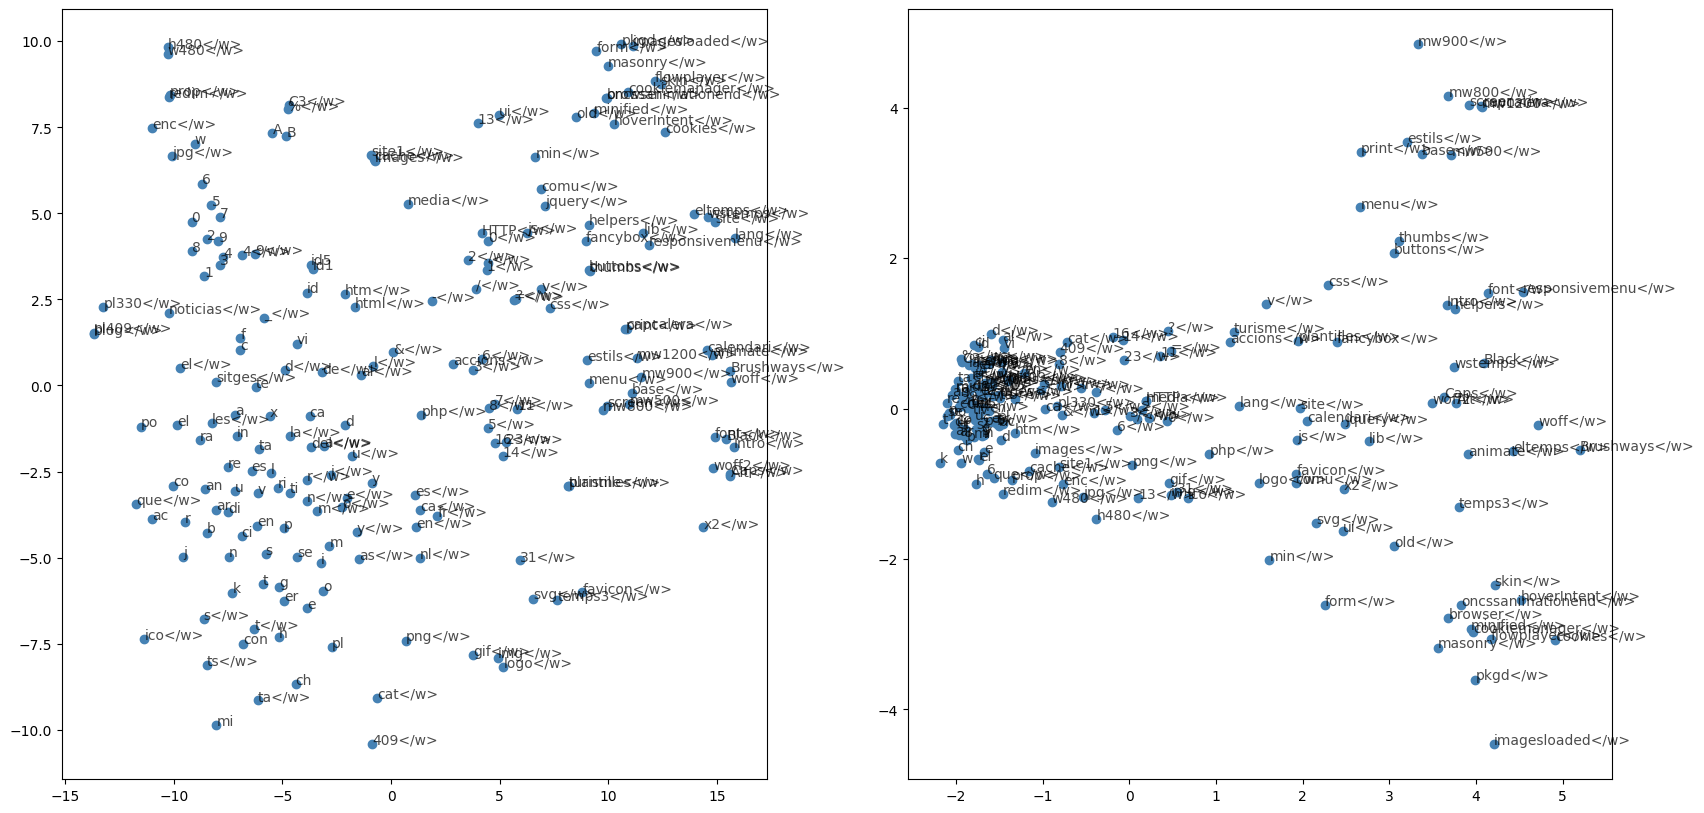

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.subplot(121)
for i in range(n):
	plt.scatter(embed_tsne[i, 0], embed_tsne[i, 1], color="steelblue")
	plt.annotate(idx2word[i], (embed_tsne[i, 0], embed_tsne[i, 1]), alpha=0.7)
plt.subplot(122)
for i in range(n):
	plt.scatter(embed_pca[i, 0], embed_pca[i, 1], color="steelblue")
	plt.annotate(idx2word[i], (embed_pca[i, 0], embed_pca[i, 1]), alpha=0.7)

In [88]:
def closest(vec, n=10):
	all_dists = [(w, torch.dist(vec, embeddings[w])) for w in idx2word.keys()]
	return [(idx2word[idx], v) for idx, v in sorted(all_dists, key=lambda t: t[1])[:n]]

def analogy(w1, w2, w3, n=5, filter_given=True):
	print('[%s : %s :: %s : ?]' % (w1, w2, w3))
   
	# w2 - w1 + w3 = w4
	w1, w2, w3 = word2idx[w1], word2idx[w2], word2idx[w3]
	closest_words = closest(embeddings[w2] - embeddings[w1] + embeddings[w3])
	
	# Optionally filter out given words
	if filter_given:
		closest_words = [t for t in closest_words if t[0] not in [w1, w2, w3]]
		
	def print_tuples(tuples):
		for tuple in tuples:
			print('(%.4f) %s' % (tuple[1], tuple[0]))

	print_tuples(closest_words[:n])

closest(embeddings[word2idx["HTTP</w>"]])

[('HTTP</w>', tensor(0.)),
 ('.</w>', tensor(2.1921)),
 ('0</w>', tensor(2.5291)),
 ('1</w>', tensor(2.8522)),
 ('2</w>', tensor(2.9539)),
 ('taules</w>', tensor(2.9727)),
 ('-</w>', tensor(3.0565)),
 ('/</w>', tensor(3.0762)),
 (',</w>', tensor(3.1849)),
 ('+</w>', tensor(3.3160))]

In [104]:
closest(embeddings[word2idx["fr</w>"]], 15)

[('fr</w>', tensor(0.)),
 ('ca</w>', tensor(2.5635)),
 ('en</w>', tensor(3.0579)),
 ('es</w>', tensor(3.2398)),
 ('re</w>', tensor(3.2971)),
 ('tion</w>', tensor(3.6508)),
 ('nl</w>', tensor(3.7149)),
 ('e</w>', tensor(3.7313)),
 ('no', tensor(3.7892)),
 ('20</w>', tensor(3.8298)),
 ('de</w>', tensor(3.8333)),
 (')</w>', tensor(3.8386)),
 ('64</w>', tensor(3.8674)),
 ('emanager</w>', tensor(3.8875)),
 ('de', tensor(3.9171))]

In [108]:
closest(embeddings[word2idx["12"]])

[('12', tensor(0.)),
 ('49</w>', tensor(1.9618)),
 ('1', tensor(1.9822)),
 ('22</w>', tensor(2.0007)),
 ('10</w>', tensor(2.0254)),
 ('4</w>', tensor(2.0952)),
 ('12</w>', tensor(2.1098)),
 ('9</w>', tensor(2.2028)),
 ('4', tensor(2.2073)),
 ('45</w>', tensor(2.2455))]

In [105]:
analogy("fr</w>", "/</w>", "ca</w>")

[fr</w> : /</w> :: ca</w> : ?]
(2.5635) /</w>
(2.9554) -</w>
(3.0345) 2</w>
(3.1466) .</w>
(3.2375) l


In [112]:
n = len(embeddings)
embeddings = torch.load(os.path.join(ROOT_DIR, 'models/embeddings_url.pt'))
embeddings.requires_grad = False
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:n, :])

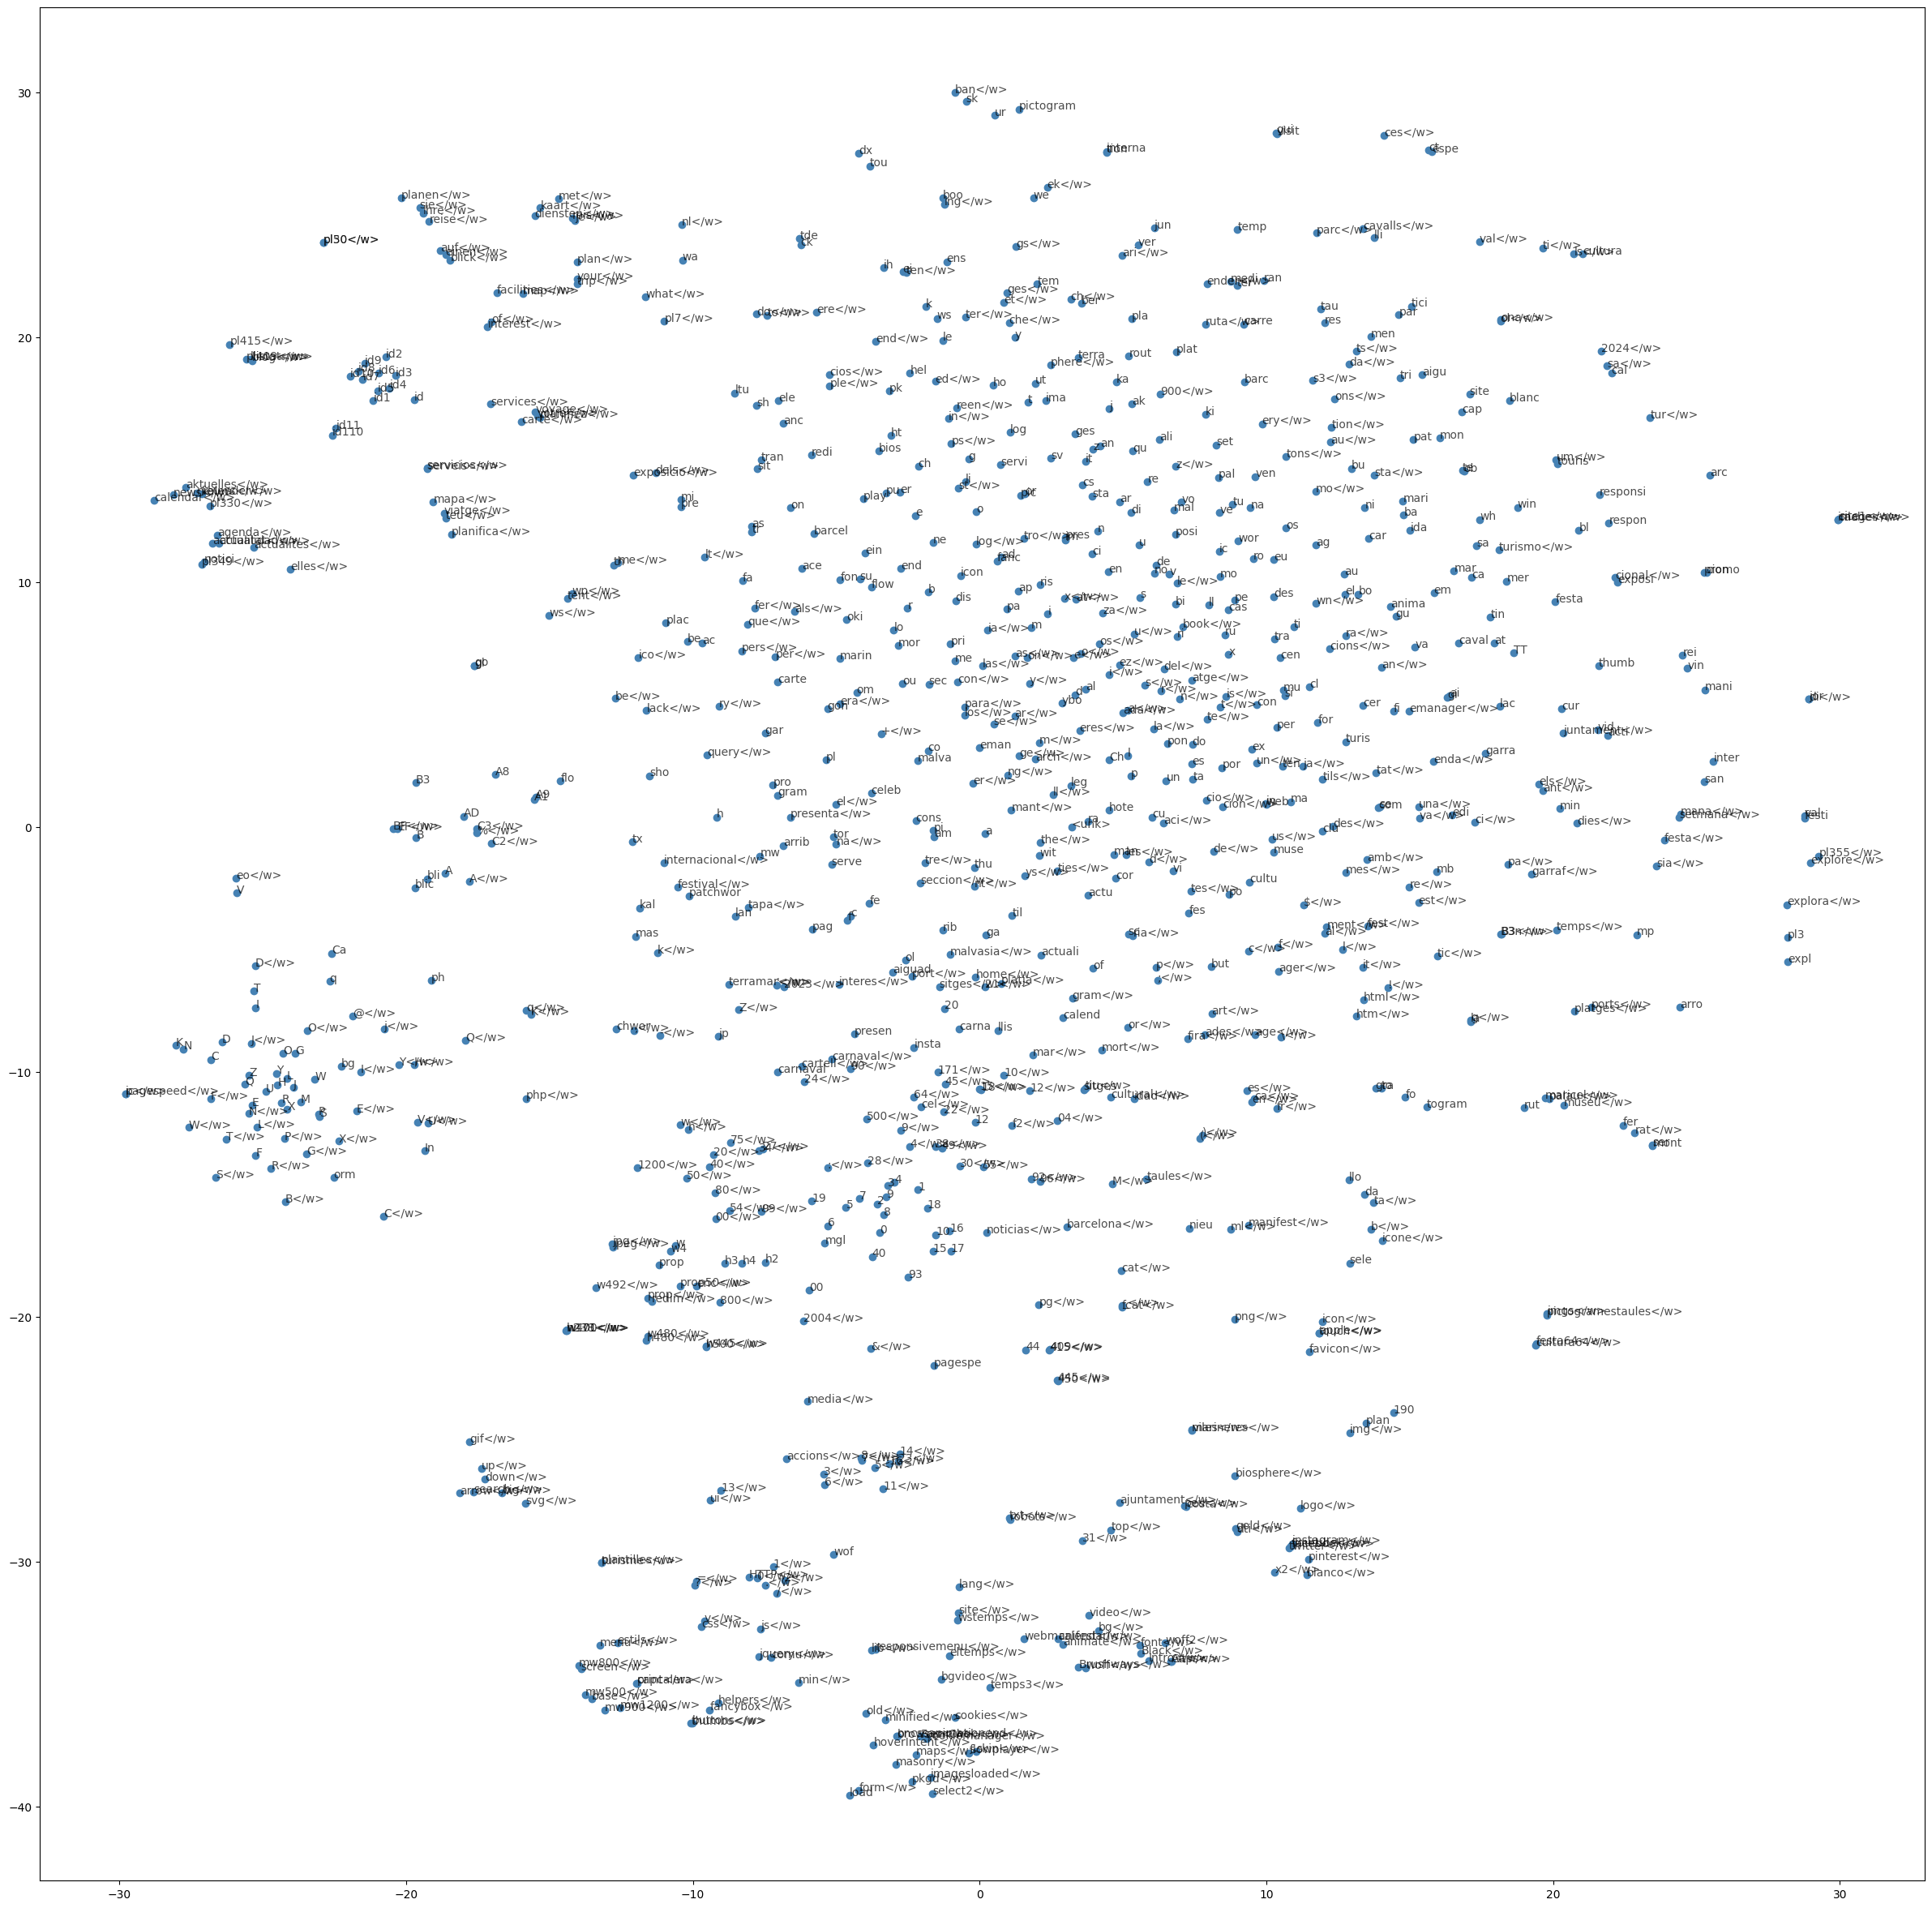

In [115]:
plt.figure(figsize=(30, 30))
for i in range(n):
	plt.scatter(embed_tsne[i, 0], embed_tsne[i, 1], color="steelblue")
	plt.annotate(idx2word[i], (embed_tsne[i, 0], embed_tsne[i, 1]), alpha=0.7)

#### Refine embeddings

In [6]:
from skipgram import *
tokenizer = load_tokenizer(os.path.join(ROOT_DIR, "models"), "charbpe-url")
tokenized_url_corpus = tokenize_corpus(corpus, tokenizer)
trimmed_url_corpus = trim_corpus(tokenized_url_corpus, 5)
word2idx, idx2word, vocab = create_lookup_tables(trimmed_url_corpus)
subsampled_url_corpus = subsample(trimmed_url_corpus, word2idx, 1e-2)

Corpus tokenized. Extracting tokens...


100%|██████████| 1076959/1076959 [00:06<00:00, 157017.23it/s]


Subsampled 9766597 tokens from the corpus. 61.64% of the corpus remaining.


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 30
batch_size = 512
context_size = 5
n_neg_samples = 5

noise_dist = generate_noise_dist(subsampled_url_corpus, len(vocab))
model = SkipGram(len(vocab), embedding_dim, noise_dist=noise_dist).to(device)
criterion = NegativeSamplingLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
train_skipgram(
	model=model,
	criterion=criterion,
	optimizer=optimizer,
	subsampled_corpus=subsampled_url_corpus,
	device=device,
	batch_size=batch_size,
	context_size=context_size,
	n_epochs=2,
	n_neg_samples=n_neg_samples,
	print_every=(50, 1000),
	idx2word=idx2word
)

Epoch  2/ 2 | Batch 30601/30646 | Loss: 1.6973
HTTP</w> | .</w>, 0</w>, 2</w>, pagespeed</w>, 1</w>
comu</w> | flowplayer</w>, jquery</w>, fancybox</w>, js</w>, skin</w>
fancybox</w> | helpers</w>, thumbs</w>, buttons</w>, jquery</w>, comu</w>
de</w> | a</w>, ci, es</w>, el</w>, con</w>
jquery</w> | js</w>, fancybox</w>, thumbs</w>, helpers</w>, capcalera</w>
ta | presen, cio</w>, tri, pu, bi
wstemps</w> | eltemps</w>, site</w>, webmanifest</w>, animate</w>, 450</w>
8 | 7, 9, 0, 4, 18
h | w, 800</w>, 500</w>, 80</w>, w4
es | cap, con</w>, im, para</w>, tu



In [19]:
path = os.path.join(ROOT_DIR, 'models/embeddings-url.pt')
save_embeddings(model, path)
embeddings_out = model.out_embed.weight.to('cpu')
torch.save(embeddings_out, os.path.join(ROOT_DIR, 'models/embeddings-url-out.pt'))
embeddings = load_embeddings(path)

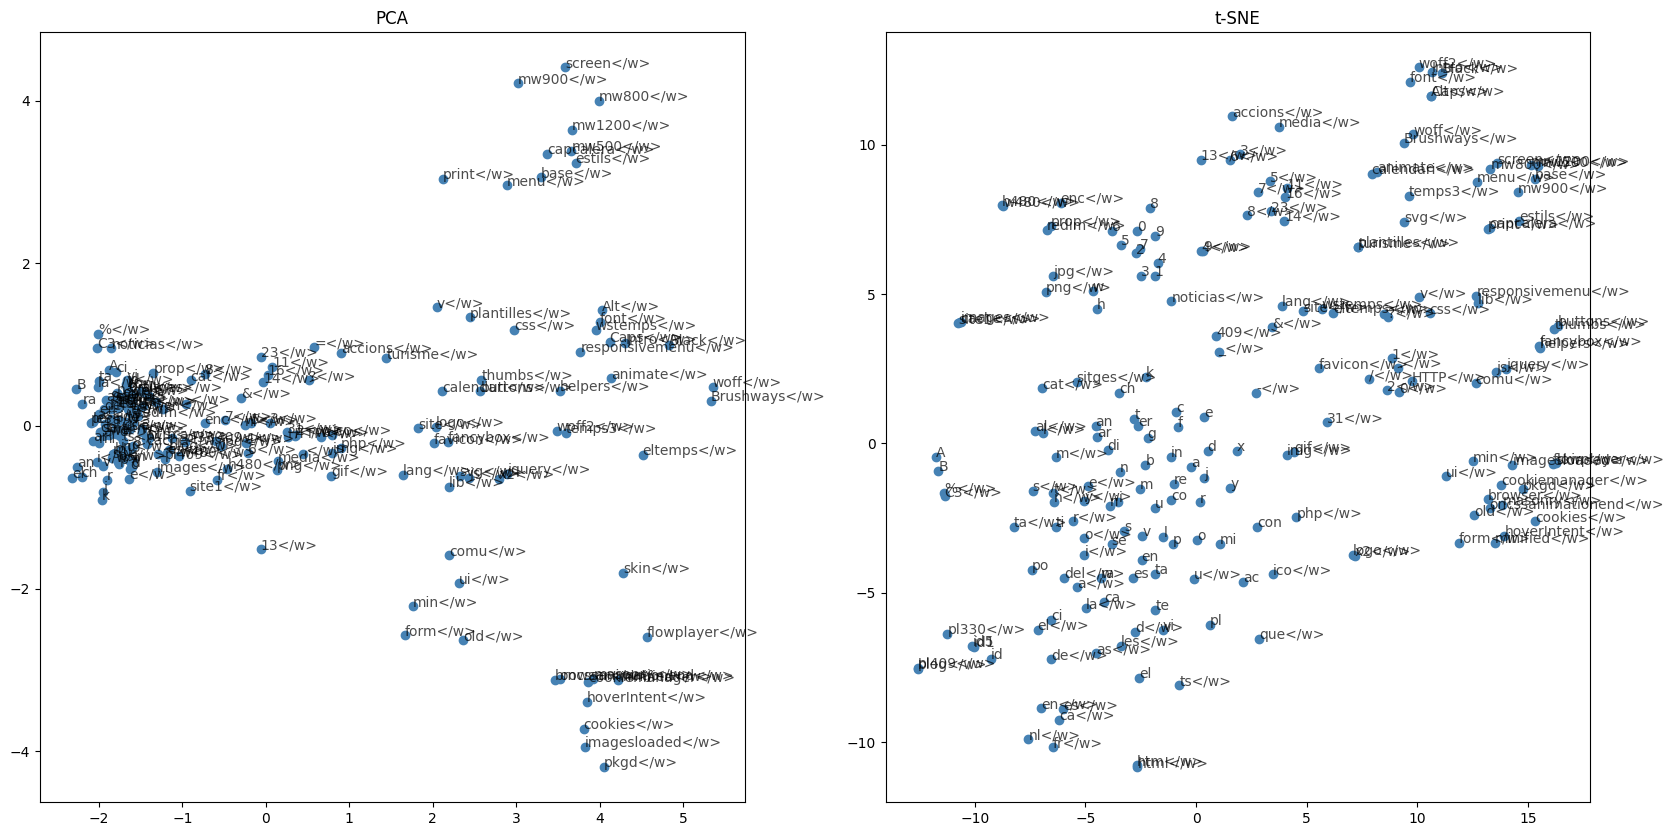

In [11]:
visualize_embeddings(
	embeddings=embeddings,
	idx2word=idx2word,
	n=200,
	method="both",
	figsize=(20, 10)
)

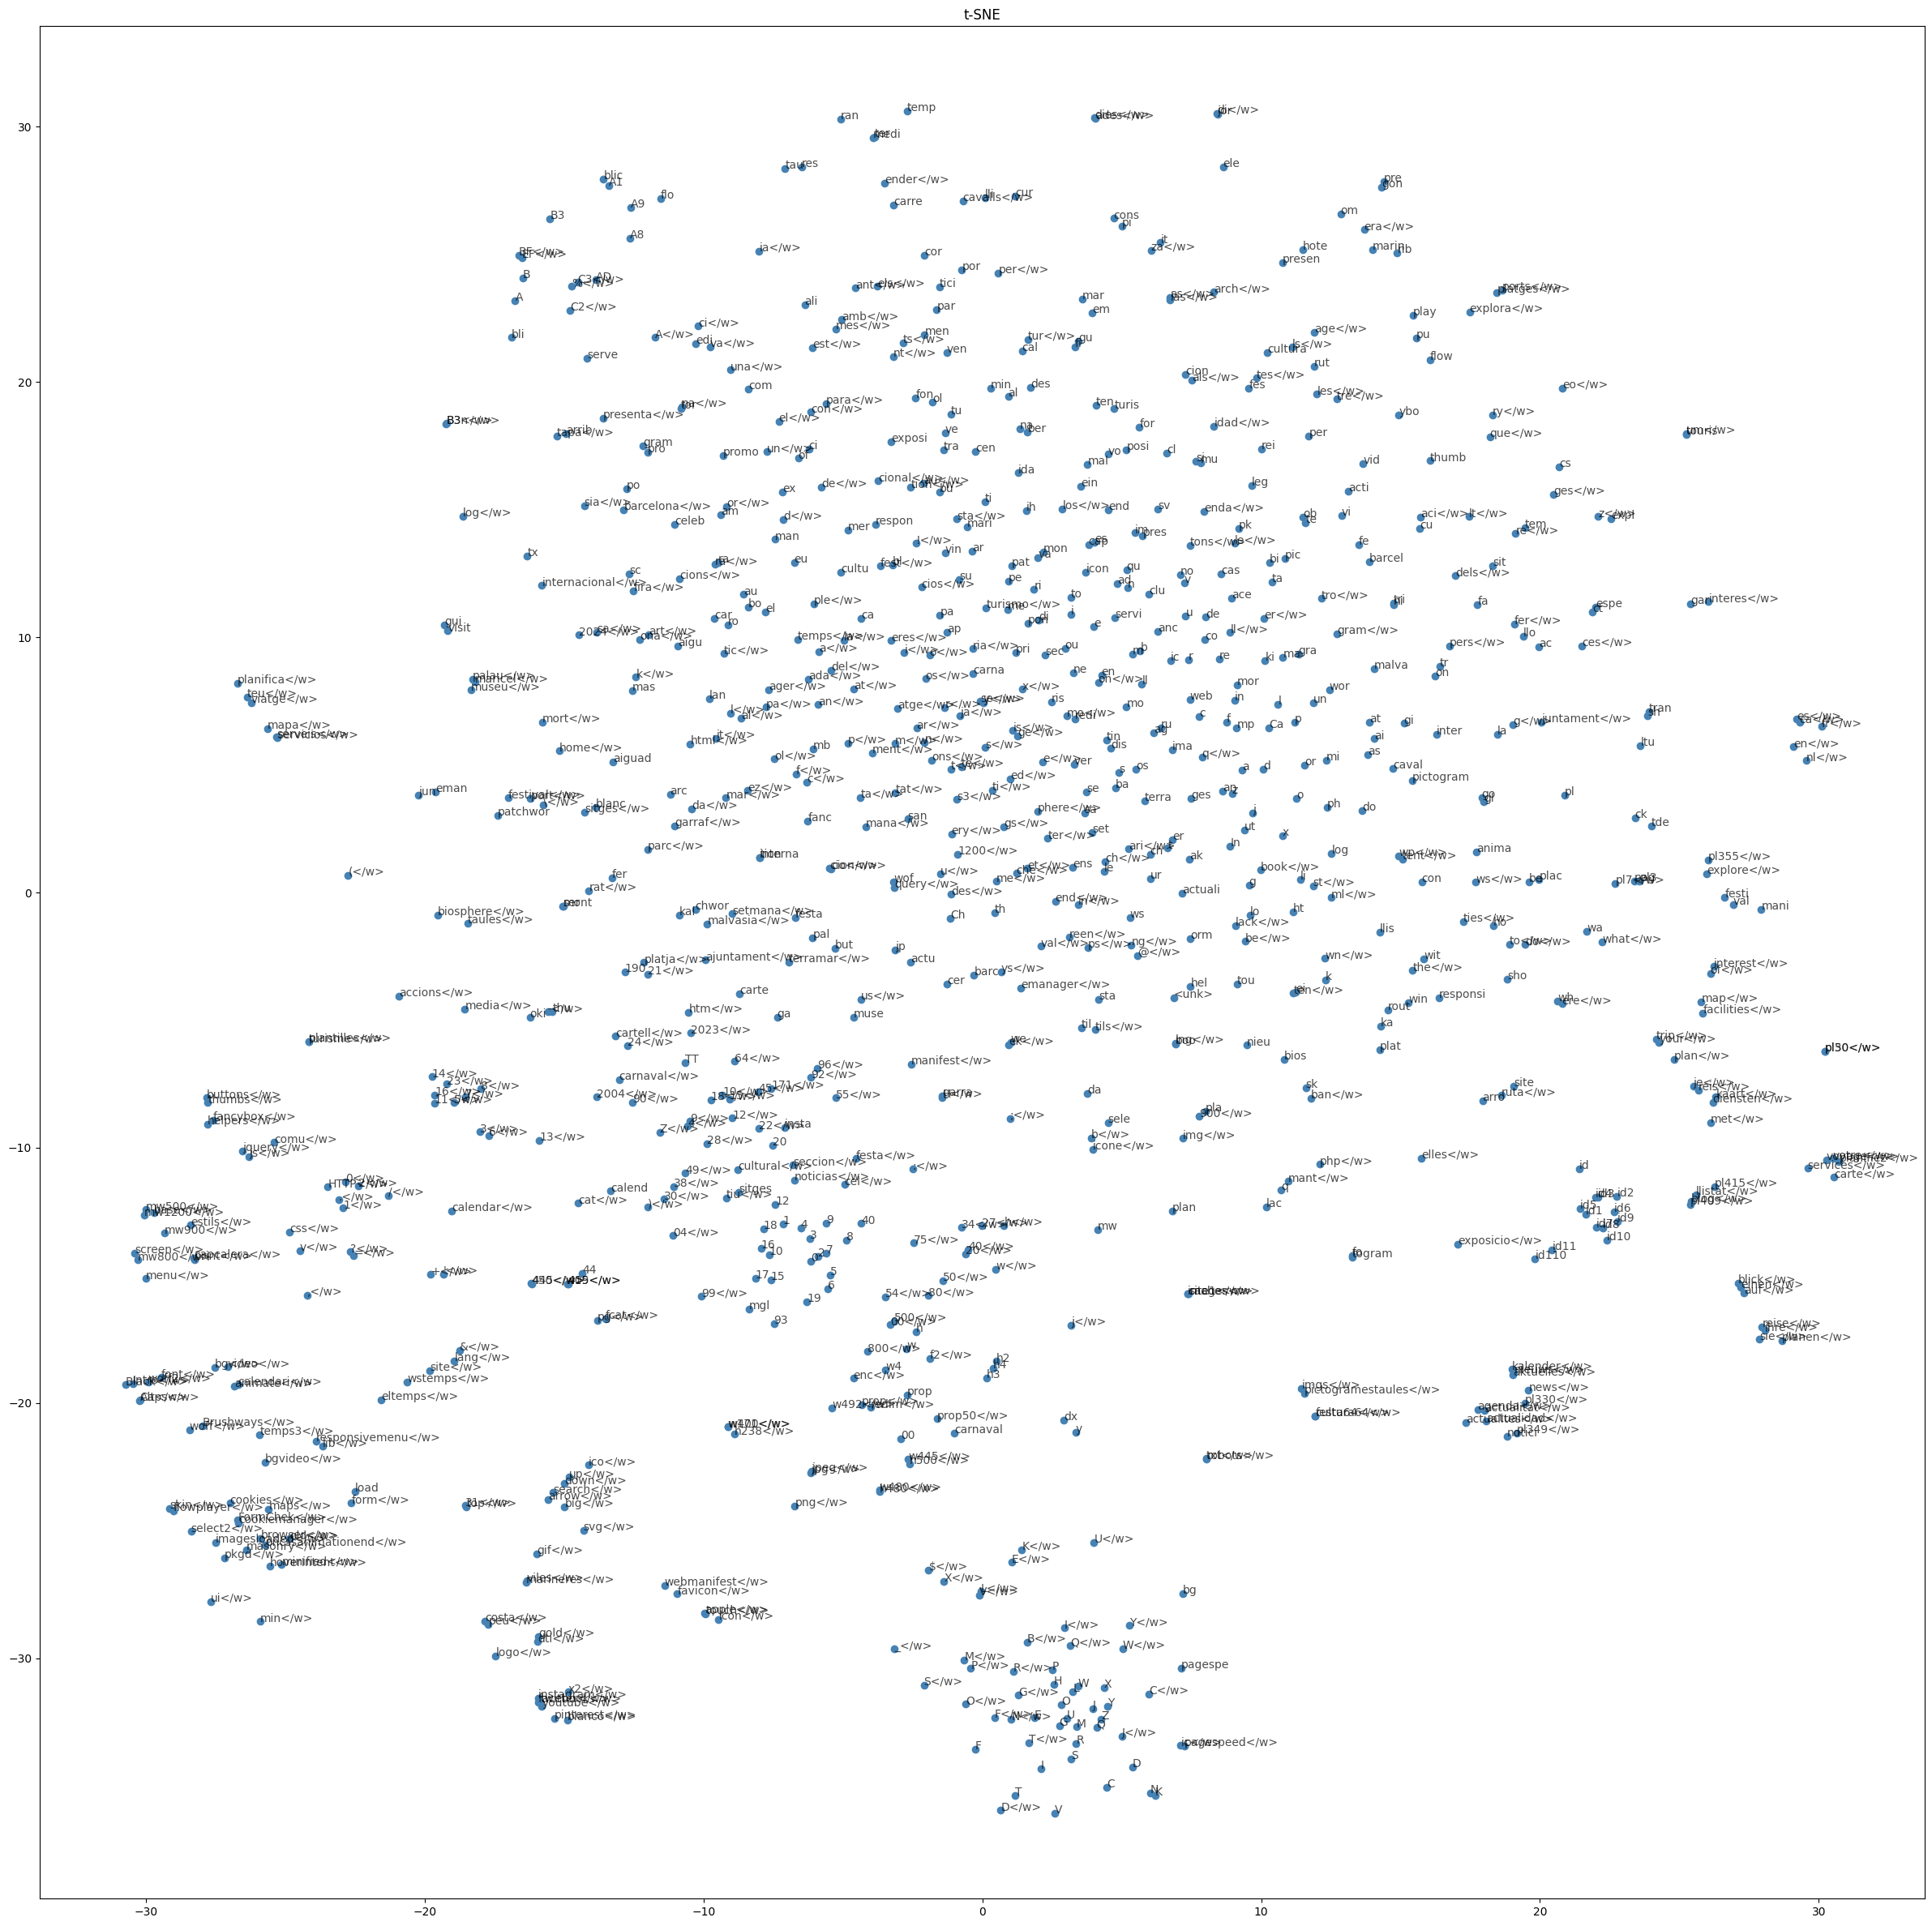

In [12]:
visualize_embeddings(
	embeddings=embeddings,
	idx2word=idx2word,
	n=embeddings.shape[0],
	method="tsne",
	figsize=(30, 30)
)

In [13]:
closest("fr</w>", embeddings, idx2word)

[('fr</w>', 0.0),
 ('ca</w>', 3.2361934185028076),
 ('en</w>', 3.528834581375122),
 ('es</w>', 3.5543627738952637),
 ('nl</w>', 3.9583568572998047),
 ('re</w>', 4.160157203674316),
 ('10</w>', 4.164087772369385),
 ('12</w>', 4.1973066329956055),
 ('55</w>', 4.202021598815918),
 ('38</w>', 4.214081764221191)]

In [14]:
closest("HTTP</w>", embeddings, idx2word)

[('HTTP</w>', 0.0),
 ('.</w>', 2.550332546234131),
 ('0</w>', 3.043837308883667),
 ('1</w>', 3.1868104934692383),
 ('2</w>', 3.2144525051116943),
 ('+</w>', 3.549579620361328),
 ('-</w>', 3.7105860710144043),
 ('thu', 3.7174017429351807),
 ('l</w>', 3.7322869300842285),
 ('2023</w>', 3.760786533355713)]

In [18]:
closest("search</w>", embeddings, idx2word)

[('search</w>', 0.0),
 ('down</w>', 2.9873299598693848),
 ('arrow</w>', 3.4739301204681396),
 ('big</w>', 3.8759725093841553),
 ('up</w>', 3.943772792816162),
 ('top</w>', 4.621969223022461),
 ('ico</w>', 4.7219743728637695),
 ('be</w>', 5.085905075073242),
 ('dti</w>', 5.181826591491699),
 ('map</w>', 5.189651012420654)]

In [20]:
closest("id11", embeddings, idx2word)

[('id11', 0.0),
 ('id1', 2.3482491970062256),
 ('id7', 2.489435911178589),
 ('id8', 2.6001129150390625),
 ('id110', 2.773165464401245),
 ('id5', 2.8783841133117676),
 ('id10', 2.9116907119750977),
 ('id9', 2.9137260913848877),
 ('id6', 2.989936590194702),
 ('10</w>', 3.1022350788116455)]